In [321]:
from geoarray import GeoArray
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter

In [322]:
# importing ISOFIT
from isofit.utils import surface_model
from isofit.core.forward import ForwardModel
from isofit.configs.configs import create_new_config
from isofit.inversion.inverse import Inversion
from isofit.core.fileio import IO

In [323]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [324]:
"""
v2m2: India campaign, fourth draft calibration, campaign start, point-spread
      function (PSF) correction, new multiple endmember spectral mixture analysis
      (MESMA), new wavelengths, new RCCs, new methane (CH4) signatures for data
      collected from 20151218 through 20160308.
        
"""
# Data Gathered over Kurnool, India
data = GeoArray('C:\\Users\\vpatro\\Desktop\\ang20160126\\ang20160126t055327_corr_v2m2_img')
data_2015_Chilika = GeoArray('C:\\Users\\vpatro\\Desktop\\ang20151228\\ang20151228t060124_corr_v2m2_img')

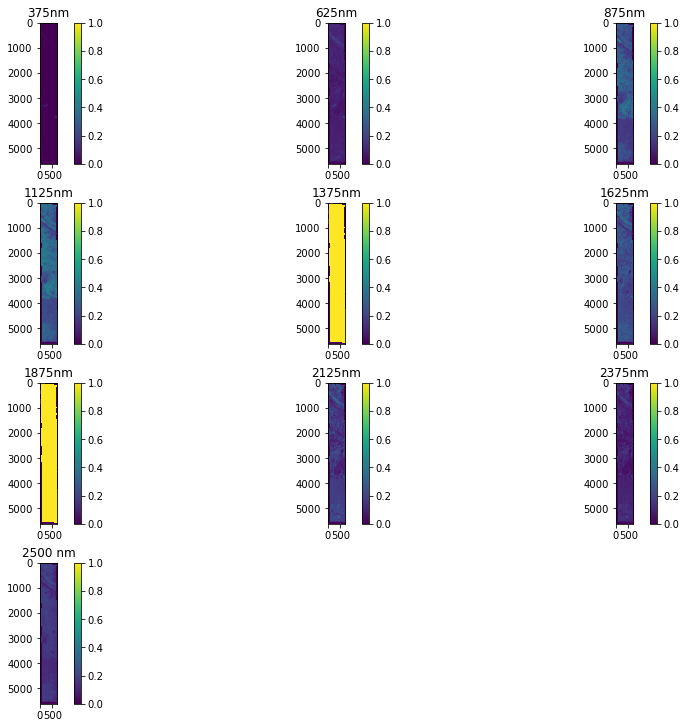

In [325]:
# Visualization of VSWIR -- entire image
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 375
channel = 0
for i in range(4):
    if i == 3:
        im = axs[i,0].imshow(data[:,:, 424])
        axs[i,0].set_title('2500 nm')
        plt.colorbar(im, ax = axs[i,0])
        im.set_clim(0,1)
        break
    for j in range(3):
        im = axs[i,j].imshow(data[:,:, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,1)
        wavelength += 250
        channel += 50
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
plt.show()

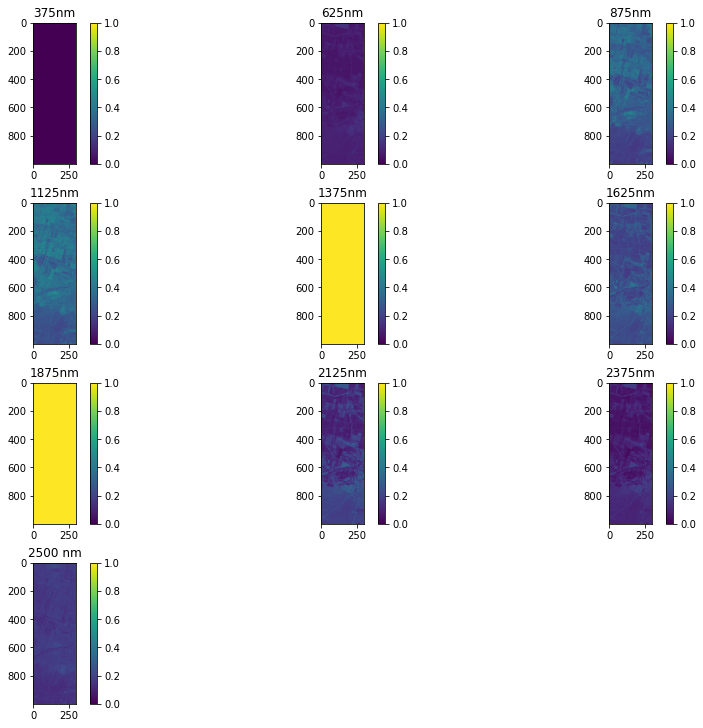

In [326]:
# Visualization of VSWIR -- zoomed in
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 375
channel = 0
for i in range(4):
    if i == 3:
        im = axs[i,0].imshow(data[2000:3000,100:400, 424])
        axs[i,0].set_title('2500 nm')
        plt.colorbar(im, ax = axs[i,0])
        im.set_clim(0,1)
        break
    for j in range(3):
        im = axs[i,j].imshow(data[2000:3000,100:400, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,1)
        wavelength += 250
        channel += 50
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
plt.show()

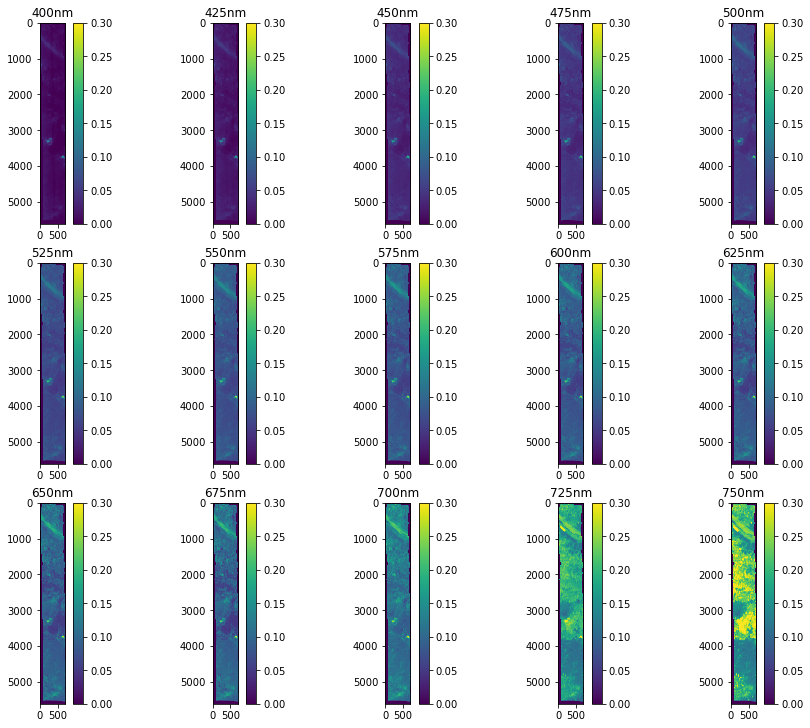

In [328]:
# Visualization of Visible Light spectrum -- entire image
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 400
channel = 5
for i in range(3):
    for j in range(5):
        im = axs[i,j].imshow(data[:,:, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,0.3)
        wavelength += 25
        channel += 5
plt.show()

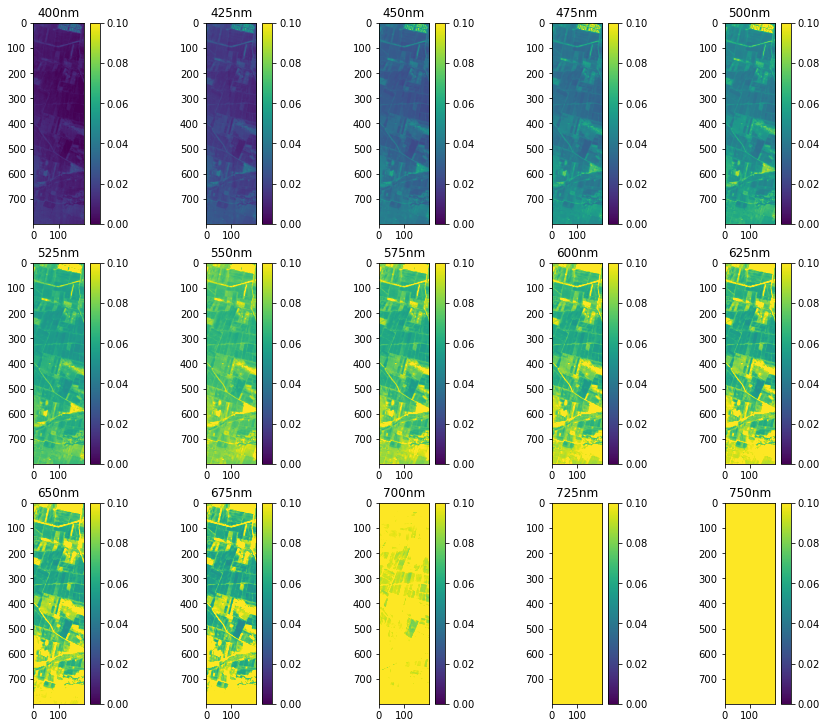

In [329]:
# Visualization of Visual Light spectrum -- zoomed in
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 400
channel = 5
for i in range(3):
    for j in range(5):
        im = axs[i,j].imshow(data[2000:2800,100:300, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,0.1)
        wavelength += 25
        channel += 5
plt.show()

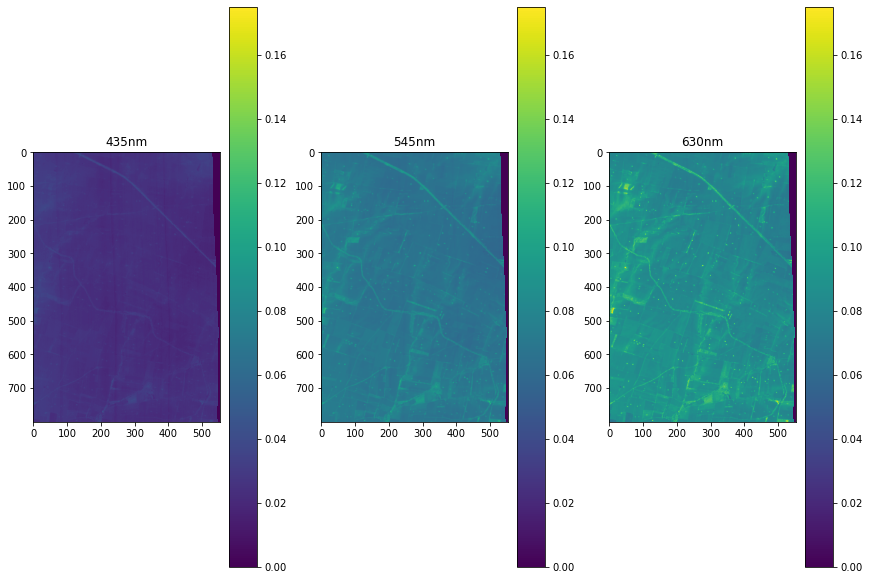

In [331]:
# Visualization at blue, green, red wavelengths
# Kurnool, India
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = [435, 545, 630]
channel = [12,34, 52]
for i in range(3):
    im = axs[i].imshow(data[4000:4800,150:, channel[i]])
    axs[i].set_title(str(wavelength[i]) + 'nm')
    plt.colorbar(im, ax = axs[i])
    im.set_clim(0,0.175)
plt.show()

In [367]:
def remove_bad_bands(spectra_list : list):
    # removes bad bands

    for spectra in spectra_list:
        # sets the indices of all bad bands to np.nan
        wavelengths = list(range(425))
        indices = list(range(425))
        for i in wavelengths:
            if i > 190 and i < 215:
                wavelengths[i] = np.nan
            if i > 280 and i < 320:
                wavelengths[i] = np.nan
            if i > 418:
                wavelengths[i] = np.nan

        bad_indices = []
        for i in range(len(wavelengths)):
            if math.isnan(wavelengths[i]):
                bad_indices.append(int(indices[i]))
            
        spectra[bad_indices] = np.nan

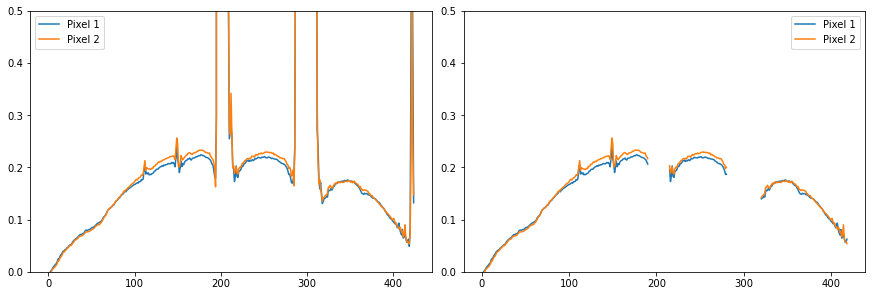

In [416]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4), constrained_layout = True)
gs = fig.add_gridspec()
spectra_1 = data[4500,250,:].copy()
spectra_2 = data[4500,600,:].copy()
axs[0].plot(spectra_1, label = 'Pixel 1')
axs[0].plot(spectra_2,label = 'Pixel 2')
axs[0].set_ylim([0,0.5])
axs[0].legend()
#axs[0].set_title('Comparison of Surface Reflectances from the Same Line of Image -- Soil')
remove_bad_bands([spectra_1, spectra_2])
axs[1].plot(spectra_1, label = 'Pixel 1')
axs[1].plot(spectra_2,label = 'Pixel 2')
axs[1].set_ylim([0,0.5])
axs[1].legend()
#axs[1].set_title('Comparison of Surface Reflectances from the Same Line of Image -- Soil')

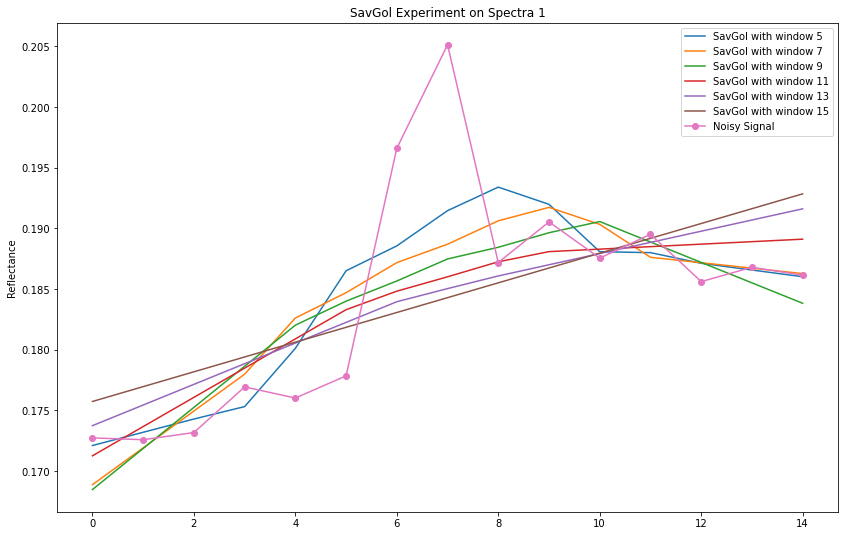

In [369]:
# Savitsky-Golay Experiment on Spectra 1
plt.figure(figsize = (14,9))
shortened_array = spectra_1[105:120].copy() # deepcopy so no reference issues any longer 
#print('spectra_1', spectra_1[105:120])
for i in range(5,17,2):
    y_filtered = savgol_filter(shortened_array,i,1)
    plt.plot(y_filtered, label = 'SavGol with window ' + str(i))
plt.plot(shortened_array, label = 'Noisy Signal', marker = 'o')
plt.legend()
plt.ylabel('Reflectance')
plt.title('SavGol Experiment on Spectra 1')

best_fit_1 = savgol_filter(shortened_array,11,1)
#print('savgol', best_fit); print('spectra_1', spectra_1[105:120])

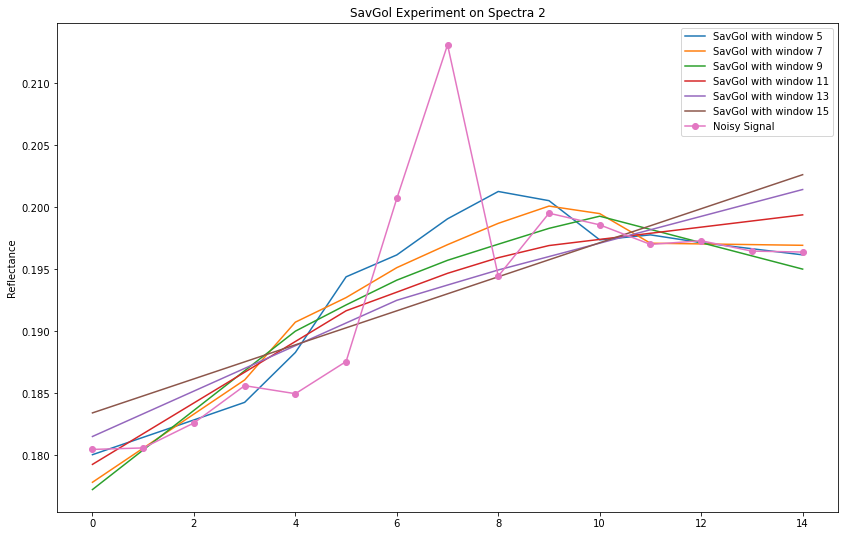

In [370]:
# Savitsky-Golay Experiment on Spectra 2
plt.figure(figsize = (14,9))
shortened_array_2 = spectra_2[105:120].copy()
for i in range(5,17,2):
    y_filtered_2 = savgol_filter(shortened_array_2,i,1)
    plt.plot(y_filtered_2, label = 'SavGol with window ' + str(i))
plt.plot(shortened_array_2, label = 'Noisy Signal', marker = 'o')
plt.legend()
plt.ylabel('Reflectance')
plt.title('SavGol Experiment on Spectra 2')

best_fit_2 = savgol_filter(shortened_array_2,11,1)
#print('savgol', best_fit); print('spectra_1', spectra_1[105:120])

In [371]:
spectra_1 = data[4500,250,:]
spectra_2 = data[4500,600,:]
old_array_1 = data[4500,250,:]
old_array_2 = data[4500,600,:]
#print('original_data before change to spectra 1', old_array[105:120])
spectra_1[105:120] = best_fit_1.copy()
spectra_2[105:120] = best_fit_2.copy()
#print('savgol', best_fit_1)
#print('spectra_1', spectra_1[105:120])
#print('original_data', old_array[105:120])

In [372]:
assert(spectra_1[105:120].all() == best_fit_1.all())
assert(spectra_2[105:120].all() == best_fit_2.all())
remove_bad_bands([spectra_1, spectra_2, old_array_1, old_array_2])

Text(0.5, 1.0, 'Comparison of Two Surface Reflectances from the Same Line of an Image -- Soil')

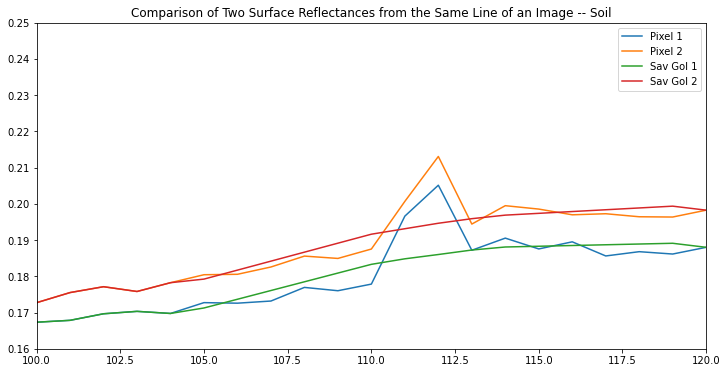

In [373]:
plt.figure(figsize = (12,6))
plt.plot(old_array_1, label = 'Pixel 1')
plt.plot(old_array_2,label = 'Pixel 2')
plt.plot(spectra_1, label = 'Sav Gol 1')
plt.plot(spectra_2, label = 'Sav Gol 2')
plt.ylim(0.16,0.25)
plt.xlim(100,120)
plt.legend()
plt.title('Comparison of Two Surface Reflectances from the Same Line of an Image -- Soil')

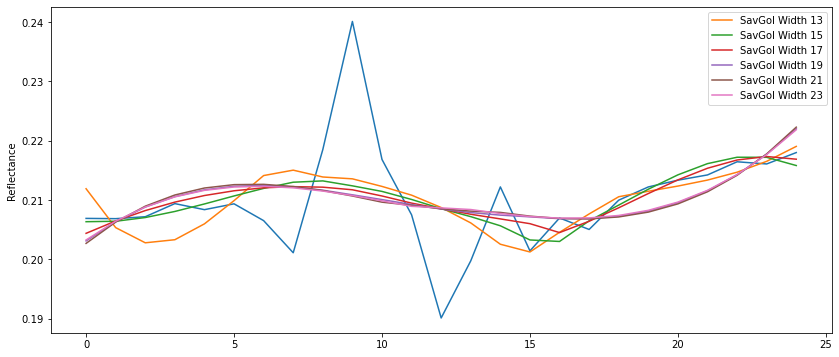

In [425]:
# second noise peak for savgol smoothening

noise = spectra_1[140:165].copy()
plt.figure(figsize = (14,6))
plt.plot(noise)
for i in range(13,24,2):
    y_filtered = savgol_filter(noise, i, 3)
    plt.plot(y_filtered, label = 'SavGol Width ' + str(i))
plt.legend()
plt.ylabel('Reflectance')
#plt.ylim(0.205, 0.23)

best_fit = savgol_filter(noise, 17, 3)

In [429]:
# SavGol smoothening 

def savgol_smoothening(spectra_list:list):
    for spectra in spectra_list:
        noise_peak_1 = spectra[105:120].copy()
        noise_peak_2 = spectra[140:165].copy()
        spectra[105:120] = savgol_filter(noise_peak_1, 11,1)
        spectra[140:165] = savgol_filter(noise_peak_2, 17, 3)
        
                       

(0.0, 0.35)

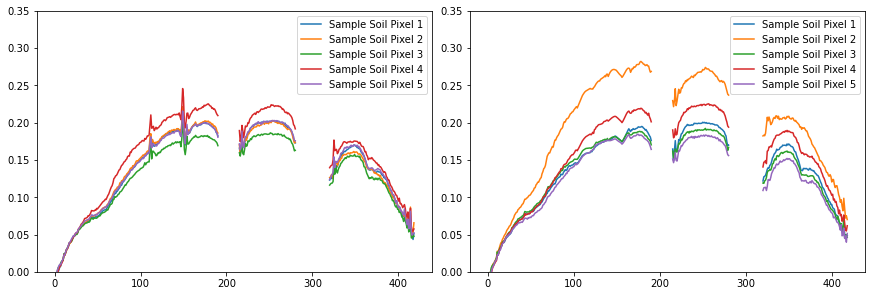

In [448]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4), constrained_layout = True)
gs = fig.add_gridspec()
for i in range(5):
    spectra = data[np.random.randint(4000,4799),np.random.randint(150,703),:].copy()
    remove_bad_bands([spectra])
    axs[0].plot(spectra, label = 'Sample Soil Pixel ' + str(i+1))
axs[0].legend()
axs[0].set_ylim(0,0.35)
#axs[0].title('Surface Reflectance Spectra of Randomly Sampled Soil Pixels in Kurnool, India -- AVIRIS-NG')
    
# Now with savgol smoothening
for i in range(5):
    spectra = data[np.random.randint(4000,4799),np.random.randint(150,703),:].copy()
    remove_bad_bands([spectra])
    savgol_smoothening([spectra])
    axs[1].plot(spectra, label = 'Sample Soil Pixel ' + str(i+1))
axs[1].legend()
axs[1].set_ylim(0,0.35)
#axs[1].title('Surface Reflectance Spectra of Randomly Sampled Soil Pixels in Kurnool, India -- AVIRIS-NG')

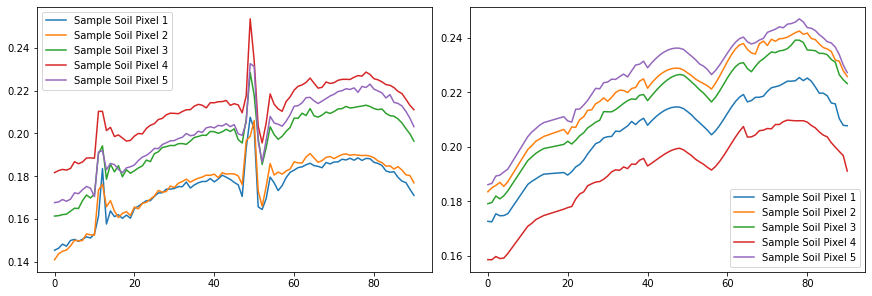

In [446]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4), constrained_layout = True)
gs = fig.add_gridspec()
for i in range(5):
    spectra = data[np.random.randint(4000,4799),np.random.randint(150,703),:].copy()
    remove_bad_bands([spectra])
    axs[0].plot(spectra[100:200], label = 'Sample Soil Pixel ' + str(i+1))
axs[0].legend()
#axs[0].set_ylim(0,0.35)
#axs[0].title('Surface Reflectance Spectra of Randomly Sampled Soil Pixels in Kurnool, India -- AVIRIS-NG')
    
# Now with savgol smoothening
for i in range(5):
    spectra = data[np.random.randint(4000,4799),np.random.randint(150,703),:].copy()
    remove_bad_bands([spectra])
    savgol_smoothening([spectra])
    axs[1].plot(spectra[100:200], label = 'Sample Soil Pixel ' + str(i+1))
axs[1].legend()
#axs[1].set_ylim(0,0.35)
#axs[1].title('Surface Reflectance Spectra of Randomly Sampled Soil Pixels in Kurnool, India -- AVIRIS-NG')

nan


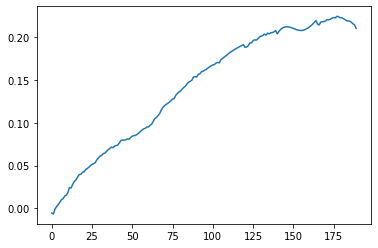

In [449]:
smoothened_close_up = spectra_1.copy()
savgol_smoothening([smoothened_close_up])
print(smoothened_close_up[195])
plt.plot(smoothened_close_up[0:190])

In [432]:
# Sample pixel for experiment - Kurnool India
avirisng_input = data[4600,500,:]

In [168]:
np.savetxt('C:\\Users\\vpatro\\Desktop\\avirisng_input.txt', avirisng_input)

In [169]:
# Surface model
surface_model("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_surface.json")


# Creating ISOFIT objects
config = create_new_config("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_beckmanlawn.json")
fm = ForwardModel(config)

x = np.loadtxt("C:\\Users\\vpatro\\Desktop\\avirisng_input.txt")
x = np.append(x,1.75)
x = np.append(x,0.05)

inv = Inversion(config, fm)
io = IO(config, fm)

io.get_components_at_index(0, 0)
geom = io.current_input_data.geom # alternately, call via geom = Geometry()...this won't have data from the above config file
meas = io.current_input_data.meas  # a numpy  array

In [170]:
OE_estimations = [[], [], [], [], []]
for i in range(5):
    radiance_measurement = fm.calc_rdn(x,geom)
    calculated_reflectance = inv.invert(radiance_measurement, geom)[0]
    OE_estimations[i] = calculated_reflectance

OE_estimations = np.array(OE_estimations)

assert(OE_estimations[0,:].all() == OE_estimations[1,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[2,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[3,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[4,:].all())


np.savetxt(r'C:\Users\vpatro\\Desktop\OE_reflectance_estimation.txt', OE_estimations)

In [174]:
# remove radiative transfer parameters

def remove_RT_parameters(spectra):
    spectra[425] = np.nan
    spectra[426] = np.nan

(0.0, 0.4)

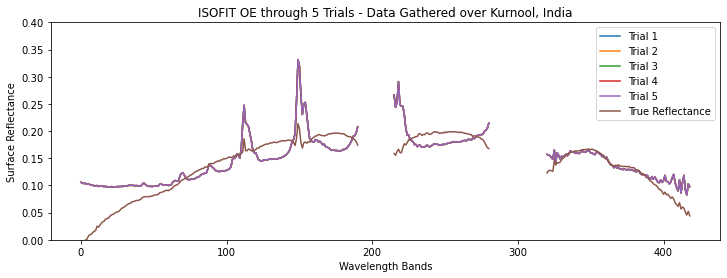

In [177]:
OE_estimated_reflectance = np.loadtxt(r'C:\Users\vpatro\\Desktop\OE_reflectance_estimation.txt')
labels = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5']
plt.rcParams["figure.figsize"]=(12,4)
for i in range(OE_estimated_reflectance.shape[0]):
    column = OE_estimated_reflectance[i,:]
    remove_bad_bands(column)
    remove_RT_parameters(column)
    plt.plot(column, label = labels[i])
    plt.title('ISOFIT OE through 5 Trials - Data Gathered over Kurnool, India')
remove_bad_bands(avirisng_input)
plt.plot(avirisng_input, label = 'True Reflectance')
plt.legend()
plt.ylabel('Surface Reflectance')
plt.xlabel('Wavelength Bands')
plt.ylim(0,0.4)


In [35]:
# ISOFIT outputs should be the same
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[1,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[2,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[3,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[4,:].all())